

# BloomTech Data Science - Neural Networks - Deploy Project
## Unit 4.2.4


Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Apply regularization techniques to your model. 

**Don't forget to switch to GPU on Colab!**


## Objectives 

In lecture, you were exposed to several regularization techniques: Lp space regularization, Max Norm weight constraints, and dropout regularization.

1: Explore the effects of these regularization techniques on model performance and on the learned model weights. 

2: Review how to save a model and how to retrieve the saved model from a file.





#### Import libraries

In [1]:
# native libraries 
import os
from time import time 

# data analysis libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning libraries 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.utils import get_file

# regularizers 
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.constraints import MaxNorm

# required for compatibility between sklearn and keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# native python unit test library
from unittest import TestCase

%matplotlib inline

-----
# Part 1: GridSearch Experiments 

The next set of experiments will involve gridsearching regularization parameter values. 

The rest of the notebook will actually require very little coding on your part. Instead, the focus is for you to run those gridsearches and answer the questions at the end of each experiment. Those questions are designed to help you capture the insights that there are to learn from each of the experiments. 

All of the following experiments are designed to help you better understand the relationship between the various regularization techniques and how they affect model performance. 


### Build Model

Let's build out the model that we'll be using all throughout our experiments. 

Remember that **the whole point of regularization is to prevent overfitting.**


![](https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png)

Overfitting happens when our models are too complex, so in order to see a benefit from the use of regularization techniques we need to build a relatively complex model. 

Having said that, you might not have the computational resource to be able to train a complex model in a reasonable amount of time. So if this describes you, then you might want to consider using `build_simple_model`. Otherwise, use `build_complex_model`. 

In this notebook, we'll use  `build_complex_model` to run our experiments. 

**NOTE:** Whichever function you end up using to build a model, take time to read through the code and make sure you understand what is happening. 

### Load the `quickdraw10` data set
using code provided in the Module 3 assignment.

In [9]:
def load_quickdraw10():
    """
    Loads and normalizes (based on max pixel value) and partitions a subset of 
    the QuickDraw dataset into training and test sets.

    Returns
    -------
    X, y : shuffled train test split
    """
    
    URL_ = "https://github.com/michael-s-luo/Neural-Networks-DS4.2/blob/main/data/quickdraw10.npz?raw=true"
    
    path_to_zip = get_file('./quickdraw10.npz', origin=URL_, extract=False)

    data = np.load(path_to_zip)
    
    # normalize your image data
    max_pixel_value = 255
    X = data['arr_0']/max_pixel_value
    Y = data['arr_1']
        
    return train_test_split(X, Y, shuffle=True)

In [10]:
X_train, X_test, y_train, y_test = load_quickdraw10()

#Quick check of train/test dimensions
print(f"Training set: X train: {X_train.shape}, y train: {y_train.shape}")

25421363/25421363 [==============================] - 0s 0us/step
Training set: X train: (75000, 784), y train: (75000,)


### Build the model

In [11]:
def build_complex_model(Lp_reg=None, reg_penalty:float=None, dropout_prob:float=0.0, maxnorm_wc:float=None):
    """
    Build and return a regularized 3 hidden layer FCFF model 
    
    Parameters
    ----------
    Lp_reg: None or object
        If object, Lp_reg is either l1 or l2 regularization 
        If None, that means that l1 or l2 regularization will not be used.
     
    reg_penalty: None or float
        If float, reg_penalty is a value typically between 1.0 and 0.0001
        This is the regularization strength for l1 or l2 
        
        
    dropout_prob: float
        This is the probability that dropout regularization will exclude a node from a training iteration. 
        If this value is 0.0, that means that dropout will not be used. 
        
    maxnorm_wc: None or float
        If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
        If None, that means that Max Norm regularization will not be used.
        
        
    Return
    ------
    model: compiled Keras model
    """

    # specify the input size
    input_dim = 28 * 28

    # specify the number of neurons in the output layer
    n_output = 10

    # if reg_type is not None, then pass in the penalty strength to whatever form of Lp space regularization this is 
    if Lp_reg is not None:
        Lp_regularizer = Lp_reg(reg_penalty)
    else:
        Lp_regularizer = None
                
    if maxnorm_wc is not None:
        wc = MaxNorm(max_value=maxnorm_wc)
    else:
        wc = None


    # instantiate Sequential class
    model = Sequential([    

    # hidden layer 1
    Dense(500, kernel_regularizer=Lp_regularizer , kernel_constraint=wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
    # act func 1
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 2
    Dense(250, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 2
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 3
    Dense(100, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 3
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # output layer   
    Dense(n_output, activation="softmax")  

    ])
    # compile model 
    model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])
    
    return model

Again, only use `build_simple_model` instead of `build_complex_model` if you're working on a machine with very limited computational resources. 

In [ ]:
# def build_simple_model(Lp_reg=None, reg_penalty=None, dropout_prob=0, maxnorm_wc=None):
#     """
#     Build and return a regularized 1 hidden layer FCFF model 
    
#     Parameters
#     ----------
#     Lp_reg: None or object
#         If object, Lp_reg is either l1 or l2 regularization 
#         If None, that means that l1 or l2 regularization will not be used.
     
#     reg_penalty: None or float
#         If float, reg_penalty is a value typically between 1.0 and 0.0001
#         This is the regularization strength for l1 or l2 
        
        
#     dropout_prob: float
#         This is the probability that dropout regularization will exclude a node from a training iteration. 
#         If this value is 0.0, that means that dropout will not be used. 
        
#     maxnorm_wc: None or float
#         If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
#         If None, that means that Max Norm regularization will not be used.
        
        
#     Return
#     ------
#     model: compiled Keras model
#     """

#    # specify the input size
#    input_dim = # YOUR CODE HERE

#    # specify the number of neurons in the output layer
#    n_output = # YOUR CODE HERE

#     if Lp_reg is not None:
#         Lp_regularizer = Lp_reg(reg_penalty)
#     else:
#         Lp_regularizer = None

#     # instantiate Sequential class
#     model = Sequential([

#     # hidden layer 1
#     Dense(128,  kernel_regularizer=Lp_regularizer, kernel_constraint=maxnorm_wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
#     # act func 1
#     ReLU(negative_slope=0.01),
#     Dropout(p_dropout),

#     # output layer   
#     Dense(n_output, activation="softmax")  

#     ])
#     # compile model 
#     model.compile(loss="sparse_categorical_crossentropy", 
#                  optimizer="adam", 
#                  metrics=["accuracy"])
    
#     return model

Since we'll be using sklearn's `GridsearchCV` class, we need to wrap our Keras models in `KerasClassifier`

In [12]:
# wrap KerasClassifier around build_model for compatibility with sklearn GridsearchCV 
model = KerasClassifier(build_fn = build_complex_model)

<ipython-input-12-2d67b99a9966>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_complex_model)


-------

# Experiment 1: Identify the relationship between model performance and L2 penalty strength

![](https://www.researchgate.net/publication/334159821/figure/fig1/AS:776025558495234@1562030319993/Ridge-regression-variable-selection.png)

_Note: <br>
In the right panel of the above diagram, **SSE** <br>
stands for "Sum of Squared Errors".<br>
In the left panel, **ESS** is a typo that should read **SSE**._<br>

We are going to run a gridsearch solely on the L2 regularization penalty value and see the effect this has on model performance. 

By running a gridseach on only a single hyperparameter (while using the same data and model) we can isolate the effect of that hyperparameter. <br><br>


In [13]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # take note that Lp_reg penalty/strength values are in powers of 10 
    "reg_penalty": [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
    # Since we only want to test l2, provide l2 as the sole option 
    "Lp_reg": [l2],
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearch run-time is too long for you
    "epochs": [3] 
}

In [14]:
start=time()
# takes about 7 min on Colab with GPU
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-3, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Epoch 1/3
1563/1563 [==============================] - 11s 4ms/step - loss: 165.4959 - accuracy: 0.1037
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3029 - accuracy: 0.0992
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 2.3029 - accuracy: 0.1010
Epoch 1/3
1563/1563 [==============================] - 9s 5ms/step - loss: 166.0060 - accuracy: 0.1008
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3028 - accuracy: 0.0997
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 2.3030 - accuracy: 0.0986
Epoch 1/3
1563/1563 [==============================] - 8s 4ms/step - loss: 165.2284 - accuracy: 0.1009
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3029 - accuracy: 0.0986
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 2.3031 - accuracy: 0.0992
Epoch 1/3
1563/1563 [=========

In [15]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 9.39 mins


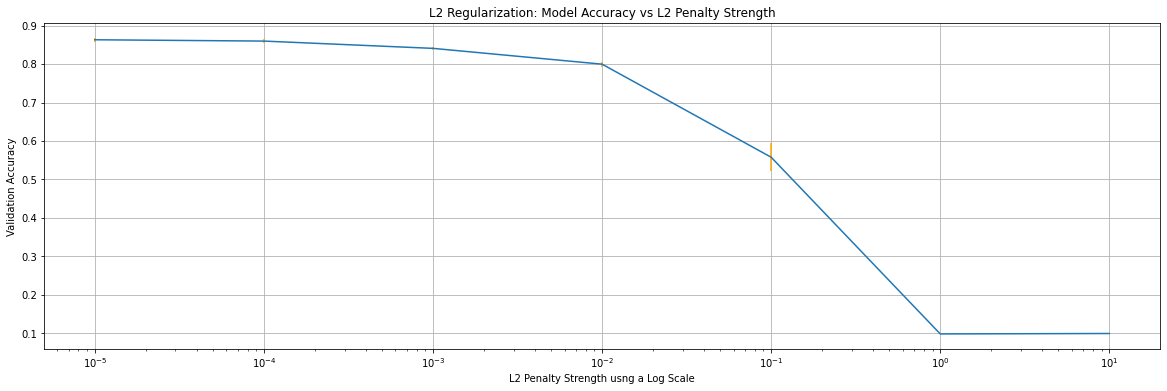

In [16]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [param_dict["reg_penalty"] for param_dict in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()

# this plot is using the std of the CV splits to plot error bars however those values are so small that they aren't visable
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.xscale("log") # use a log scale for ease of reading, recall that l2_reg_penalty were in powers of 10 
plt.title("L2 Regularization: Model Accuracy vs L2 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("L2 Penalty Strength usng a Log Scale");

### Observations



The lowest l2 regularization penalties actually yielded the highest validation accuracy. This likely means that our model was already relatively generalizable and that regularization (at least with l2) is not needed when epochs = 3. However, we may see improvements in val accuracy over baseline (no regularization) if training continues past the convergence of train and val accuracy.

Higher l2 regularization in this grid search yielded lower accuracy, until a steep dropoff at or beyond 1 penalized model parameters so much so that val accuracy equaled baseline random class predictions. 


## Compare Weights between the Best Model and a Worse Model 

Next, we are going to compare the hidden layer weights between the best and worst performing model while taking note of the respective L2 penalty strengths.

In [19]:
# get the best l2 penalty term 
best_lr_penalty = grid_result.best_params_["reg_penalty"]

# get the best trained model
#     a model that is wrapped in the KerasClassifier wrapper doesn't have a .get_weights() method.
#     So this is the workaround to generate a version of the model that does have a .get_weights() method
best_model = grid_result.best_estimator_.build_fn(Lp_reg=l2, reg_penalty=best_lr_penalty)

# get the weights from the best trained model 
best_weights = best_model.get_weights()

In [63]:
# train a model using the l2_reg_penalty value that scored the lowest 
worse_l2_reg_penalty = 10.0

worse_model = build_complex_model(Lp_reg=l2, reg_penalty=worse_l2_reg_penalty)

# fit model 
worse_model.fit(X_train, y_train, epochs=3)

# get weights from worst performing model 
worse_weights = worse_model.get_weights()

Epoch 1/3
2344/2344 [==============================] - 10s 4ms/step - loss: 111.6054 - accuracy: 0.0991
Epoch 2/3
2344/2344 [==============================] - 9s 4ms/step - loss: 2.3030 - accuracy: 0.0975
Epoch 3/3
2344/2344 [==============================] - 9s 4ms/step - loss: 2.3032 - accuracy: 0.0993


-----
## Understanding how Weights and Biases are stored

Let's take a minute to understand that`.get_weights()` returns a list with 8 elements (if you're using `build_complex_model`).

In [21]:
len(best_weights)

8

There are **weights matrices and bias vectors between each layer** and we have 5 layers. The last 4 layers are composed of neurons. 

- Input
- Hidden 1
- Hidden 2
- Hidden 3
- Output 

So we should have a weight matrix and a bias vector from each neuron layer, <br>which accounts for $4 + 4 = 8$ elements in the list.


#### Index for Weight Matrices 
If you index for a weight matrix, you can see its shape and that they are indeed matrices. 

Notice how you can see the dims of the layers that the matrices are sandwiched between?

The input layer has 784 dims and hidden layer 1 has 500 neurons. <br>
So the first weight matrix should have a column of weights for each neuron; and each column has 784 weights.
Given this understanding, the numbers you see in the shapes of the weight and bias arrays should make sense. 

In [22]:
# bewteen input and 1st hidden layer
best_weights[0].shape

(784, 500)

In [23]:
# bewteen 1st and 2nd hidden layer
best_weights[2].shape

(500, 250)

In [24]:
# bewteen 2nd and 3rd hidden layer
best_weights[4].shape

(250, 100)

In [25]:
# bewteen 3rd hidden layer and output layer
best_weights[6].shape

(100, 10)

#### Index for the bias vectors

The shapes of the bias vectors should exactly match up the dims/nodes of each layer (excluding the input layer). 

In [27]:
# for hidden layer 1 
best_weights[1].shape

(500,)

In [28]:
# for hidden layer 2 
best_weights[3].shape

(250,)

In [29]:
# for hidden layer 3
best_weights[5].shape

(100,)

In [30]:
# for output layer
best_weights[7].shape

(10,)

-----

### Back to our Analysis of L2 space regularization (also known as Ridge)

To gauge the performance effect of L2 regularization, we'll compare the weights for the 1st hidden layer from the best and worst performing models from our hyperparameter search space, as well as with the initial weight values that are randomly sampled from the GlorotUniform distribution.

[**Check out the Keras docs for the Dense layer**](https://keras.io/api/layers/core_layers/dense/), you'll see that GlorotUniform is the default weight initializer. 

Read the docs to figure out how to get the weights from a Keras dense layer.
Also have a look at this helpful post on StackOverflow: [**How to view initialized weights (i.e. before training)?**](https://stackoverflow.com/questions/46798708/how-to-view-initialized-weights-i-e-before-training)


Before we compare weights, let's take note of the following. 

Both `best_weights[0]` or `worse_weights[0]` are matrices with shape `(784, 500)`. 

If we flatten them, then we get `784 * 500 = 392000` weights. What does this mean exactly?

Remember that we are working with the Fully Connected Feed-Forward model which looks something like this. 

![](https://pyimagesearch.com/wp-content/uploads/2016/08/simple_neural_network_header.jpg)

In Fully Connected neural network models, the outputs from a layer become the inputs for the next layer. Each output from a layer is passed as an input to all the nodes in next layer.<br>
Our input layer has $784$ output weights which are the pixel values in the image. Each neuron (or node) in hidden layer $1$ also has $784$ weights, one for each pixel input.  Hidden layer 1 has $500$ neurons. So the weights are conveniently represented as a **weights matrix** with $784$ rows (one row for each pixel in the input image) and $500$ columns (one column for each neuron in the layer). The $i$th column of the weights matrix holds the $784$ weights $\textbf{w}_{i}$ belonging to the $i$th neuron in the layer.

To keep our analysis simple, we are going to analyze only the weights corresponding to the first neuron in hidden layer $1$, whose weights $\textbf{w}_{1}$ are the first column of the weight matrix.  <br><br>

We will observe the effect of L2 regularization on neuron 1 in hidden layer 1.


In [64]:
# index for the 1st column (784 entries) in the 1st hidden layer weights in best_weights and save to best_hidden_weights
best_hidden_weights = best_weights[0][0]

# index for the 1st column (784 entries) in the 1st hidden layer weights in worse_weights and save to worse_hidden_weights
worse_hidden_weights = worse_weights[0][0]

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 
# instantiate GlorotUniform and sample 784 weights and save to initial_weight_values
initializer = GlorotUniform()
initial_weight_values = initializer(shape=(500,)).numpy()

# Build a data frame with these 3 vectors as columns


In [65]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df = pd.DataFrame(data=data).T
df.columns = cols

In [66]:
df.head()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
0,0.004209,8.321555e-40,0.054352
1,0.049470,-1.060418e-38,0.006994
2,0.054391,3.143040e-39,-0.026735
3,-0.034653,-9.311069e-39,0.030901
4,0.053963,3.720840e-40,0.019960


In [67]:
# check out the statistics for each weight column 
df.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,500.000000,5.000000e+02,500.000000
mean,-0.003350,4.589313e-08,0.000161
std,0.039069,1.110531e-06,0.044894
min,-0.067621,-4.586677e-06,-0.077133
25%,-0.036921,-5.129874e-39,-0.040759
50%,-0.004336,1.045202e-39,0.002512
75%,0.030210,6.094998e-39,0.039203
max,0.068096,2.416921e-05,0.077263


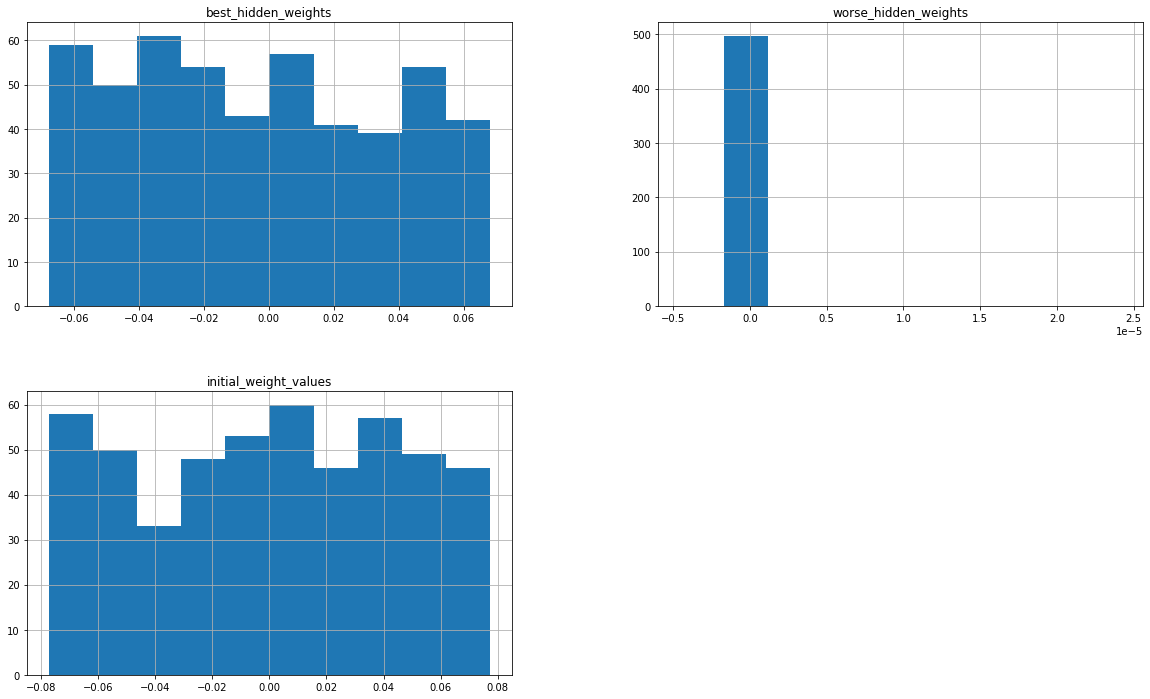

In [68]:
# plot the distributions for each weight column 
df.hist(figsize=(20,12));
# Remember, these are weights of ONLY the 1st neuron in the 1st hidden layer. 
# Histogram of all weights is expected to be normally distributed

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

They seem similar in shape; both retain a relatively flat distribution at this bucket size. Width of the distribution (max to min) values of the best models is slightly shorter than that of the initial weights due to slight l2 regularization over 3 epochs.

**What was the effect of using a small L2 penalty value (regularization constant)?**

Width of the distribution (max to min) values of the best models is slightly shorter than that of the initial weights due to slight l2 regularization over 3 epochs.

**What was the effect of using a large L2 penalty value?**

It compressed the weight distribution to almost a single point around zero.
Relative to the other distributions, this one's weights fit all into one bucket.

**Given what you know about L2 regularization, are you surprised by these results?**

Most definitely not. Since L2 penalizes the square of fitted parameters, it makes sense that a high regularization strength such as >=10 would lead to weights and biases between [-1.0, 1.0] as the squares of this decimal range result in an even smaller penalty term.

----

# Experiment 2: Identify the relationship between model performance and Max Norm Weight Constraint

![](https://qph.fs.quoracdn.net/main-qimg-9d0dbf8074761b541ba80543ddfc9f73.webp)

Recall from lecture that the **norm** of a vector is another word for the **length** of the vector.

`MaxNorm` weight constraint puts a limit on the norm of the weight vector.

The effect that Lp regularization and `MaxNorm` regularization have on the weights is similar, but they go about it in different ways. 

While Lp regularization (L1/Lasso and L2/Ridge) shrink the weight values by imposing constraints on their L1 and L2 norms, `MaxNorm` regularization shrinks the weight values by imposing a limit on the norm of a weight vector. Here's how it works: if an update would push the norm of a weight vector above MaxNorm, a scale factor is applied to all the weights so as to shrink the norm back to MaxNorm. 

In this experiment, we'll run another gridseach, similar to the one we ran for L2 regularization in the previous experiment. This time, we are going to gauge the effect of `MaxNorm` regularization on model performance and the distribution of the learned weights. As in the previous experiment, we will simplify our analysis by focusing on the weights for the first neuron in the first hidden layer.

Since we already built our model, we just need to update the `hyper_parameters` dictionary. 

In [69]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    
    "maxnorm_wc": np.linspace(0.5, 10.0, num=10), 
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearche run-time are too long for you    
    "epochs": [3] 
}

hyper_parameters

{'maxnorm_wc': array([ 0.5       ,  1.55555556,  2.61111111,  3.66666667,  4.72222222,
         5.77777778,  6.83333333,  7.88888889,  8.94444444, 10.        ]),
 'epochs': [3]}

In [70]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/3
1563/1563 [==============================] - 8s 4ms/step - loss: 0.7483 - accuracy: 0.7655
Epoch 2/3
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5956 - accuracy: 0.8147
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.5379 - accuracy: 0.8360
Epoch 1/3
1563/1563 [==============================] - 8s 4ms/step - loss: 0.7362 - accuracy: 0.7691
Epoch 2/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5900 - accuracy: 0.8177
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.5667 - accuracy: 0.8257
Epoch 1/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.7407 - accuracy: 0.7669
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5937 - accuracy: 0.8169
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.5634 - accuracy: 0.8260
Epoch 1/3
1563/1563 [===============

In [71]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 15.3 mins


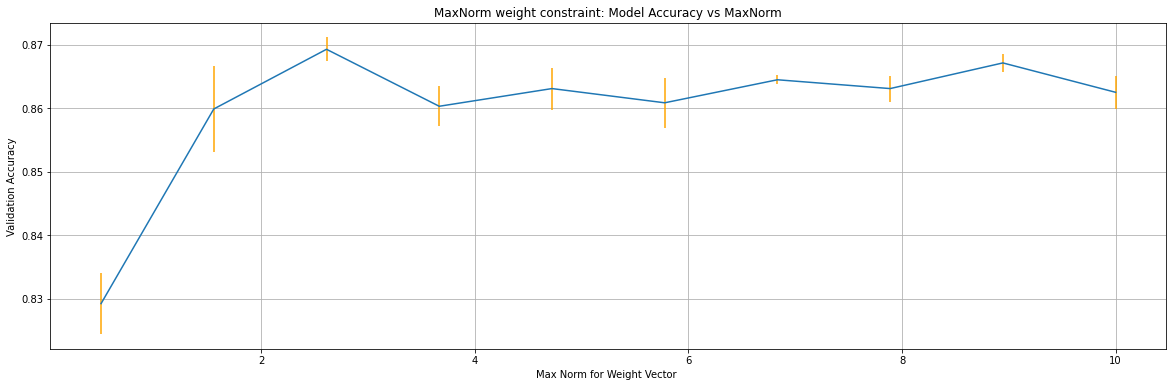

In [72]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [param_dict["maxnorm_wc"] for param_dict in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.title("MaxNorm weight constraint: Model Accuracy vs MaxNorm")
plt.ylabel("Validation Accuracy", )
plt.xlabel("Max Norm for Weight Vector ");

In [77]:
# get the best value of max norm from grid and save to best_max_norm_val
best_max_norm_val = params[2]['maxnorm_wc']

# get the best trained model from grid and save to best_model
best_model = grid.best_estimator_.build_fn(maxnorm_wc=best_max_norm_val) 

# get the weights from the best trained model and save to best_weights
best_weights = best_model.get_weights()


In [79]:
# we can verify that the norm of our weights are indeed b elow the maximum allowed value 
np.linalg.norm(best_weights[0][0])

0.8726982

In [81]:
# train a model using the max_norm_val value that scored the lowest 
worst_max_norm_val = param_values[np.argmin(means)]

# build a model using build_complex_model and worse_max_norm_val and save it to worse_model
model_worst_max_norm = build_complex_model(maxnorm_wc=worst_max_norm_val)

# fit model 
model_worst_max_norm.fit(X_train, y_train, epochs=3)

# get weights from worse performing model 
worst_weights = model_worst_max_norm.get_weights()


Epoch 1/3
2344/2344 [==============================] - 14s 5ms/step - loss: 0.6967 - accuracy: 0.7837
Epoch 2/3
2344/2344 [==============================] - 11s 5ms/step - loss: 0.5794 - accuracy: 0.8207
Epoch 3/3
2344/2344 [==============================] - 15s 6ms/step - loss: 0.5625 - accuracy: 0.8259


Sample the initial weights from the `Glorot Uniform Weight Initializer`, for comparison

In [86]:
# index for the 1st hidden layer weights in best_weights and save to best_hidden_weights
best_hidden_weights = best_weights[0][0]

# index for the 1st hidden layer weights in worse_weights and save to worse_hidden_weights
worse_hidden_weights = worst_weights[0][0]

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 
initializer = GlorotUniform()

# instantiate GlorotUniform and sample 500 weights and save to initial_weight_values
# hint: use shape=(1, 500)
initial_weight_values = initializer(shape=(500,)).numpy()


In [87]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df_maxnorm= pd.DataFrame(data=data).T
df_maxnorm.columns = cols

In [88]:
df_maxnorm.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,500.000000,5.000000e+02,500.000000
mean,-0.000374,8.583311e-06,-0.000061
std,0.039066,1.180616e-04,0.045378
min,-0.068202,-6.254945e-04,-0.077049
25%,-0.033403,-1.258230e-07,-0.040242
50%,0.001262,-4.697691e-11,0.001753
75%,0.032069,1.833920e-07,0.040769
max,0.068177,1.644326e-03,0.076487


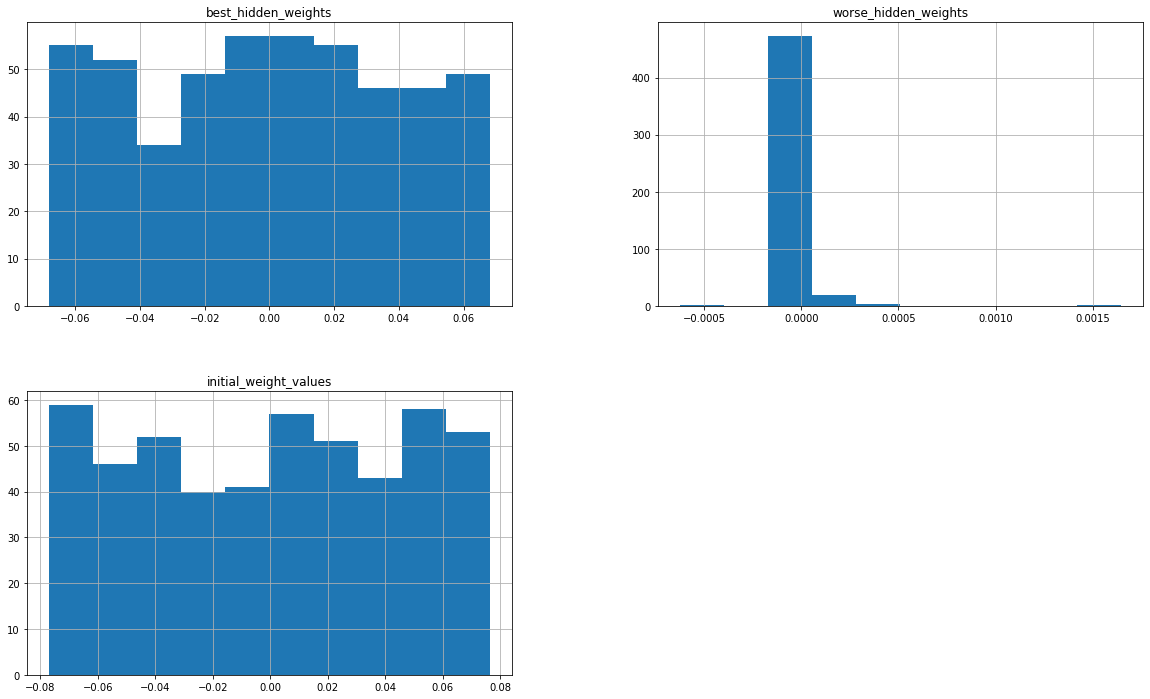

In [89]:
# plot the distributions for each weight column 
df_maxnorm.hist(figsize=(20,12));

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

The distributions are very similar at this bucket size.

**What was the effect of using the weight constraint value in MaxNorm in the best performing model?**

The distribution of weights using MaxNorm in the best performing model is narrower, roughly between -0.07 to 0.07 versus -0.08 to 0.08 of the initial weight values.

**What was the effect of using the weight constraint value in MaxNorm in the worse performing model?**

The constraint pushed nearly all of the weights to a very compressed/tight distribution around 0. When the MaxNorm constraint is low and restrictive, only a handful of neurons have weights beyond this range.

**Given what you know about MaxNorm regularization, are you surprised by these results?**

These results are hardly surprising. Since MaxNorm puts a cap on all the weights for a neuron, it positively correlates with the weight values, which is what we observe. The width, mean, and standard deviation of weights move in the direction of the constraint.

-----
# Experiment 3: Identify the relationship between model performance and Dropout


![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

In the 3rd experiment, we will use gridsearch to see how varying the value of the the dropout probability affects model performance. 

Recall from lecture that dropout tends to perform best when used with `MaxNorm` regularization. Since this is the case, we will gridsearch both dropout probability and the weight constraint for `MaxNorm`. 

If interested, feel free to read (or just skim) through the original publication on [**Drop Out**](https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf). 

**Key Take aways:** 

1. During training, dropout will probabilistically "turn off" some neurons in the layer that dropout is implemented in. 
2. During inference (ie. making predictions on the test set) all neurons are used (i.e. no dropout is applied).
3. Dropout works best when used with MaxNorm


In [91]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # for the sake of runtime, let's vary maxnorm_wc between 0.5 and 5.0
    "maxnorm_wc": np.linspace(0.5, 5, num=5),
    "dropout_prob": np.linspace(0.0, 0.6, num=5), 
    "epochs": [4] # default is 1, in order to change it we must provide value here because we can provide a parameter value for model.fit() directly when using gridsearch
}

hyper_parameters

{'maxnorm_wc': array([0.5  , 1.625, 2.75 , 3.875, 5.   ]),
 'dropout_prob': array([0.  , 0.15, 0.3 , 0.45, 0.6 ]),
 'epochs': [4]}

In [92]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Epoch 1/4
1563/1563 [==============================] - 8s 4ms/step - loss: 0.7432 - accuracy: 0.7670
Epoch 2/4
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5963 - accuracy: 0.8149
Epoch 3/4
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5723 - accuracy: 0.8229
Epoch 4/4
782/782 [==============================] - 3s 3ms/step - loss: 0.5816 - accuracy: 0.8160
Epoch 1/4
1563/1563 [==============================] - 8s 4ms/step - loss: 0.7448 - accuracy: 0.7692
Epoch 2/4
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5914 - accuracy: 0.8175
Epoch 3/4
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5633 - accuracy: 0.8255
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.5519 - accuracy: 0.8293
Epoch 1/4
1563/1563 [==============================] - 8s 4ms/step - loss: 0.7386 - accuracy: 0.7684
Epoch 2/4
1563/1563 [=============

In [93]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 51.6 mins


In [94]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

Since there are 2 independent hyperparameters which affect the validation accuracy (`dropout_prob` and `maxnorm_wc`), <br> 
we need a two-dimensional plot. A heat map will work. 

In [95]:
dropout_prob_list = [param_dict["dropout_prob"]  for param_dict in params]
maxnorm_wc_list = [param_dict["maxnorm_wc"]  for param_dict in params]
data = [means, dropout_prob_list, maxnorm_wc_list ]

cols = ["val_acc", "dropout_prob", "maxnorm_wc"]
df_exp3 =pd.DataFrame(data=data).T
df_exp3.columns = cols
df_exp3.dropout_prob = df_exp3.dropout_prob.round(2)

df_exp3

,val_acc,dropout_prob,maxnorm_wc
0,0.820147,0.00,0.500
1,0.857493,0.00,1.625
2,0.863240,0.00,2.750
3,0.865267,0.00,3.875
4,0.866707,0.00,5.000
5,0.825867,0.15,0.500
6,0.862427,0.15,1.625
7,0.863013,0.15,2.750
8,0.864907,0.15,3.875
9,0.862760,0.15,5.000


In [ ]:
df_exp3.pivot()

In [96]:
# pivot dataframe in preparation for heat map
df_exp3 = df_exp3.pivot("maxnorm_wc", "dropout_prob", "val_acc")
df_exp3

dropout_prob,0.00,0.15,0.30,0.45,0.60
maxnorm_wc,,,,,
0.500,0.820147,0.825867,0.813853,0.809693,0.796227
1.625,0.857493,0.862427,0.852427,0.845160,0.827760
2.750,0.863240,0.863013,0.859187,0.848160,0.833573
3.875,0.865267,0.864907,0.860040,0.849253,0.830160
5.000,0.866707,0.862760,0.861147,0.850800,0.831507


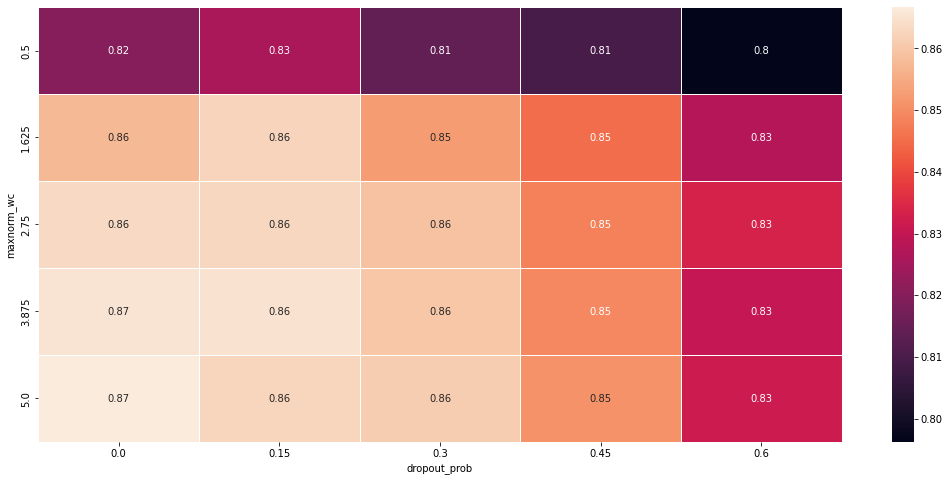

In [97]:
# Draw a heatmap with the val_acc values in each cell
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(df_exp3, annot=True,  linewidths=.5, ax=ax);

### Observations 

We can see the dropout probabilities in the horizontal axis and the `MaxNorm` weight constraint values in the vertical axis. The values in the cells are the validation accuracy that corresponds to a pair of regularization values.

Take a look at the heat map and answer the following questions. Note that depending on which model you used (the simple or complex one) your answers might be different from that of others. 

**What range of dropout probability values tend to produce the highest validation accuracy?**

The range, inclusive, from 0.0 to 0.3

**What range of maxnorm weight constraints tend to produce the highest validation accuracy?**

The range, inclusive, from 1.625 to 5.0

**When taken together, what combinations of dropout probability and maxnorm weight constraints tend to produce the highest validation accuracy?**

0 dropout probability combined with 5.0 MaxNorm yielded the highest validation acc of 0.87

**Do you think that using dropout was helpful in increasing model performance?**

This gridsearch had an important limitation: the number of epochs. The batch sizes and learning rates were also set to the default value. Dropout did not help model performance in this case as 0 yielded the best results. As epochs increase, dropout may yield marginal gains in validation accuracy when its absence will overfit the model.

_____

#Part 2: Model Deployment
# Experiment 4: Train, Save, and Load a Keras model

Let's get some practice with how to save and load trained Keras models 

For this experiment, review the section on Saving and Loading models from the guided project, then: 

- Build a model of your choosing
- Gridsearch the model with a method of your choosing
- Save the trained model to a file
- Load the trained model from the file
- Just as we did in the Guided Project, evaluate the loaded model using a test set and verify that the results of the loaded model match that of the original model that was saved.

In [99]:
# Let's repeat the previous gridsearch with a different parameter space:

# build out our hyperparameter dictionary 
hyper_parameters = {
    # for the sake of runtime, let's vary maxnorm_wc between 0.5 and 5.0
    "maxnorm_wc": np.linspace(1, 4, num=3),
    "dropout_prob": np.linspace(0.0, 0.5, num=5), 
    "epochs": [10] # default is 1, in order to change it we must provide value here because we can provide a parameter value for model.fit() directly when using gridsearch
}


# Create and run Grid Search
start=time()
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.6695 - accuracy: 0.7916
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4889 - accuracy: 0.8508
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.4461 - accuracy: 0.8628
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.4178 - accuracy: 0.8709
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4055 - accuracy: 0.8746
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3932 - accuracy: 0.8786
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3877 - accuracy: 0.8800
Epoch 8/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3774 - accuracy: 0.8822
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3755 - accuracy: 0.8835
Epoch 10/10
782/782 [

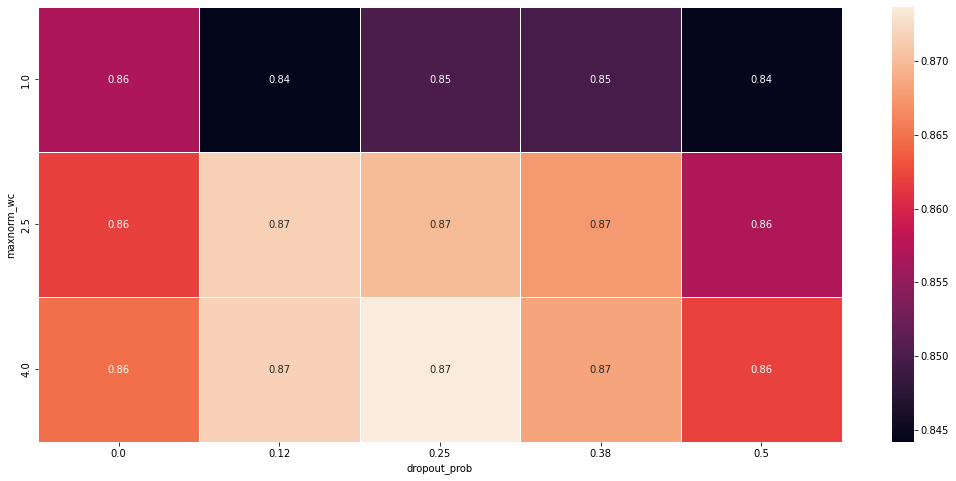

In [100]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# Build our DataFrame for visualization
dropout_prob_list = [param_dict["dropout_prob"]  for param_dict in params]
maxnorm_wc_list = [param_dict["maxnorm_wc"]  for param_dict in params]
data = [means, dropout_prob_list, maxnorm_wc_list ]

cols = ["val_acc", "dropout_prob", "maxnorm_wc"]
df_exp3 =pd.DataFrame(data=data).T
df_exp3.columns = cols
df_exp3.dropout_prob = df_exp3.dropout_prob.round(2)

# pivot dataframe in preparation for heat map
df_exp3 = df_exp3.pivot("maxnorm_wc", "dropout_prob", "val_acc")
df_exp3

# Draw a heatmap with the val_acc values in each cell
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(df_exp3, annot=True,  linewidths=.5, ax=ax);

In [119]:
# Remake the model, then save for deployment
best_model_index = np.argmax(means)
best_dropout = grid.best_params_['dropout_prob']
best_maxnorm = grid.best_params_['maxnorm_wc']

# Retrain the model using the best params
best_model = build_complex_model(dropout_prob=best_dropout, maxnorm_wc=best_maxnorm)
best_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
2344/2344 [==============================] - 12s 4ms/step - loss: 0.7179 - accuracy: 0.7812
Epoch 2/10
2344/2344 [==============================] - 11s 5ms/step - loss: 0.5257 - accuracy: 0.8431
Epoch 3/10
2344/2344 [==============================] - 11s 5ms/step - loss: 0.4685 - accuracy: 0.8599
Epoch 4/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.4295 - accuracy: 0.8713
Epoch 5/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.3991 - accuracy: 0.8801
Epoch 6/10
2344/2344 [==============================] - 11s 5ms/step - loss: 0.3764 - accuracy: 0.8864
Epoch 7/10
2344/2344 [==============================] - 11s 5ms/step - loss: 0.3557 - accuracy: 0.8921
Epoch 8/10
2344/2344 [==============================] - 11s 5ms/step - loss: 0.3334 - accuracy: 0.8986
Epoch 9/10
2344/2344 [==============================] - 11s 4ms/step - loss: 0.3199 - accuracy: 0.9029
Epoch 10/10
2344/2344 [==============================] - 11s 5ms/step - l

In [120]:
# Save the model manually
# !mkdir saved_models

best_model.save("saved_models/my_model")

In [121]:
# Load the model and make predictions

loaded_model = tf.keras.models.load_model("saved_models/my_model")

print(loaded_model.evaluate(X_train, y_train))

loaded_model.evaluate(X_test, y_test)

2344/2344 [==============================] - 7s 3ms/step - loss: 0.2132 - accuracy: 0.9346
[0.21317382156848907, 0.9346266388893127]
782/782 [==============================] - 2s 3ms/step - loss: 0.4214 - accuracy: 0.8783


[0.4213653802871704, 0.8783199787139893]